In [79]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from tmap.tda import mapper, Filter
from tmap.tda.cover import Cover
from tmap.tda.plot import Color
from tmap.tda.metric import Metric
from tmap.tda.utils import optimize_dbscan_eps
from tmap.netx.SAFE import SAFE_batch, get_SAFE_summary
from tmap.test import load_data
from scipy.spatial.distance import squareform,pdist
import pandas as pd
import os

In [80]:
# load taxa abundance data, sample metadata and precomputed distance matrix
# X = load_data.FGFP_genus_profile()
# metadata = load_data.FGFP_metadata_ready()
# dm = squareform(pdist(X,metric='braycurtis'))
# X.head()
import pandas as pd
raw = pd.read_csv("taxonomy.csv",index_col=0) # specie
#raw = pd.read_csv("Daniel/taxonomyfamily.fil.txt",index_col=0) # family
X = raw.T
X.head()

ID,Butyrivibrio_crossotus,GGB3614_SGB4886,GGB1630_SGB2238,Paraprevotella_clara,Ruminococcus_bromii,GGB1380_SGB1883,Phocaeicola_vulgatus,GGB1146_SGB1472,Phocaeicola_dorei,GGB6608_SGB9342,...,GGB28369_SGB40949,GGB4250_SGB5751,GGB45600_SGB15302,Clostridium_porci,Blautia_liquoris,Clostridium_cuniculi,Mediterraneibacter_catenae,GGB27782_SGB40196,Leclercia_adecarboxylata,Enterobacter_kobei
SRR5946989,0.0,0.0,0.0,0.00000,0.00000,0.0,6.65468,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR5983265,0.0,0.0,0.0,0.00000,0.48611,0.0,0.23675,0.0,7.44563,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR5946777,0.0,0.0,0.0,3.48134,0.12196,0.0,7.53330,0.0,0.33739,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR5946822,0.0,0.0,0.0,0.00000,0.00000,0.0,26.48135,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR5946857,0.0,0.0,0.0,0.00000,5.68323,0.0,20.94219,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
#metadata = pd.read_csv("metadata.csv",index_col=2) #sample metadata
#metadata = metadata.drop('Diagnosis', axis=1) 
#metadata = metadata.drop('Project', axis=1) 

#metadata.head()

In [82]:
#Z = pd.read_csv("pathways.txt",index_col=0, sep='\t') #sample metadata with patways
Z = pd.read_csv("pred_camda_hipca_RFT_edi_index.csv",index_col=0, sep=',') #sample metadata with index francisco
#metadata = Z.T
metadata = Z #sample metadata with index francisco
metadata.head()

,RFT_prob,hipca_Combined
SRR5946989,0.931843,1.199524
SRR5983265,0.898253,0.428842
SRR5946777,0.941046,0.887885
SRR5946822,0.033514,2.684654
SRR5946857,0.882468,1.245958


In [83]:
dm = squareform(pdist(X,metric='braycurtis')) #precomputed distance matrix

In [84]:
# TDA Step1. initiate a Mapper
tm = mapper.Mapper(verbose=1)

In [85]:
# TDA Step2. Projection
metric = Metric(metric="precomputed")
lens = [Filter.MDS(components=[0, 1], metric=metric, random_state=100)]
projected_X = tm.filter(dm, lens=lens)

Filtering by MDS.
...calculate Filter(which used to create cover) using the provided precomputed lens.


/opt/tljh/user/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



Filtering has been completed.


In [86]:
# Step4. Covering, clustering & mapping
eps = optimize_dbscan_eps(X, threshold=95)
clusterer = DBSCAN(eps=eps, min_samples=3)
cover = Cover(projected_data=MinMaxScaler().fit_transform(projected_X), resolution=61, overlap=0.91)
graph = tm.map(data=X, cover=cover, clusterer=clusterer)
print(graph.info())

n_iter = 1000
enriched_scores = SAFE_batch(graph,
                     metadata=pd.concat([X,metadata],axis=1),
                     n_iter=n_iter,
                     _mode = 'enrich')
safe_summary = get_SAFE_summary(graph=graph,
                            metadata=pd.concat([X,metadata],axis=1),
                            safe_scores=enriched_scores,
                            n_iter=n_iter,
                            p_value=0.01)

100%|██████████| 3721/3721 [00:01<00:00, 2159.67it/s]


Mapping on data (613, 2115) using lens (613, 2)
...minimal number of points in hypercube to do clustering: 3
...create 486 nodes.
...calculate projection coordinates of nodes.
...construct a TDA graph.
...create 2096 edges.
Finish TDA mapping

Graph
Contains 486 nodes and 391 samples
During constructing graph, 222 (63.78%) samples lost

Used params:

cluster params
algorithm: auto
eps: 28.320648883560203
leaf_size: 30
metric: euclidean
metric_params: None
min_samples: 3
n_jobs: None
p: None
cover params
r: 61
overlap: 0.91
lens params
lens_0:
components: [0, 1]
metric: precomputed




100%|██████████| 1000/1000 [00:50<00:00, 19.82it/s]


# Driver species analysis

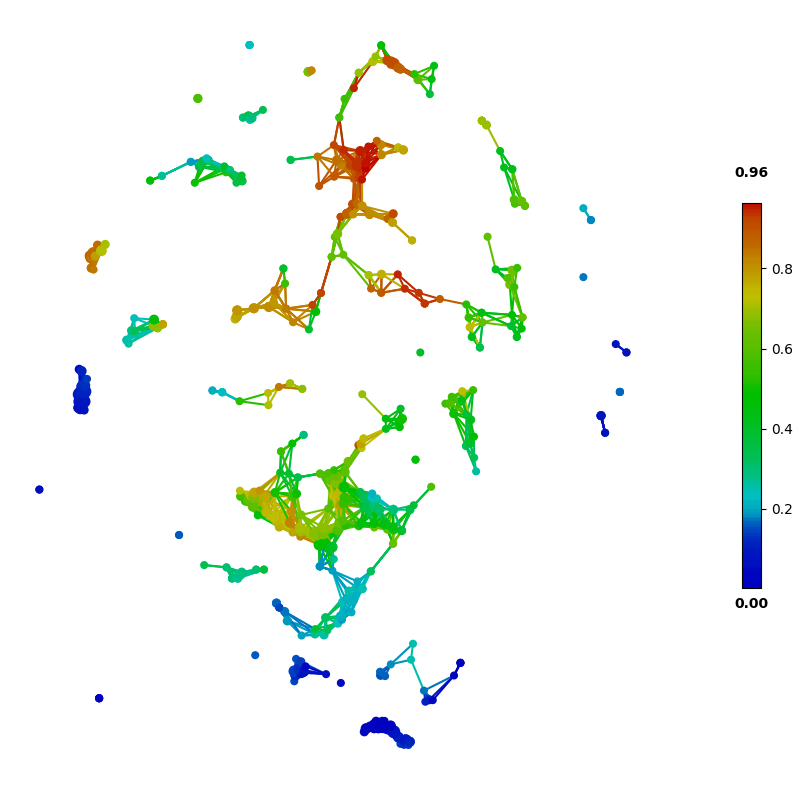

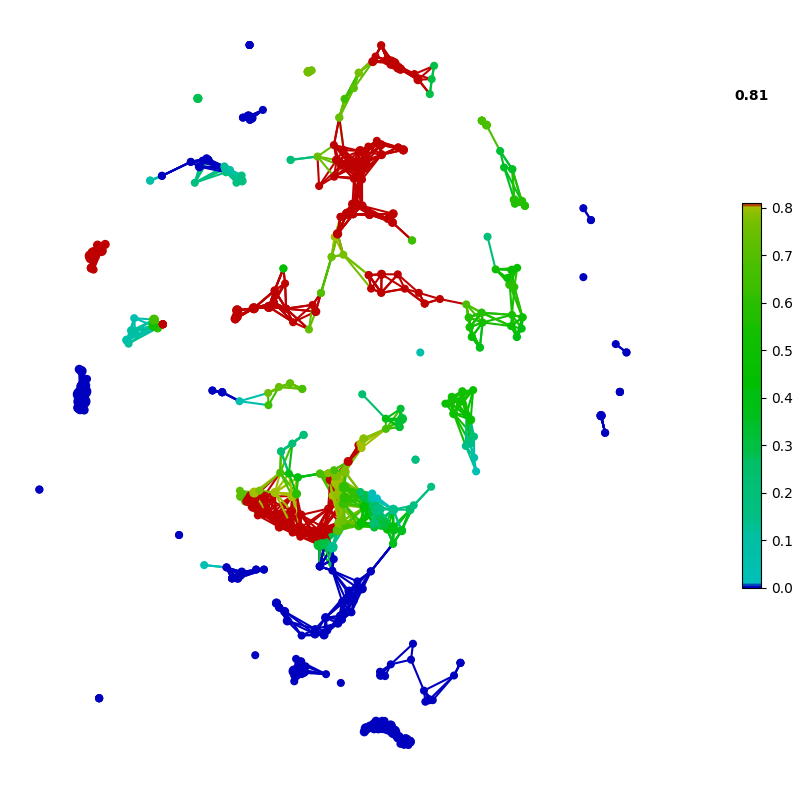

In [88]:
from tmap.tda.plot import Color
color = Color(metadata.loc[:,'RFT_prob'],target_by='sample',dtype='numerical')
graph.show(color=color)

color = Color(enriched_scores.loc[:,'RFT_prob'],target_by='node',dtype='numerical')
graph.show(color=color)

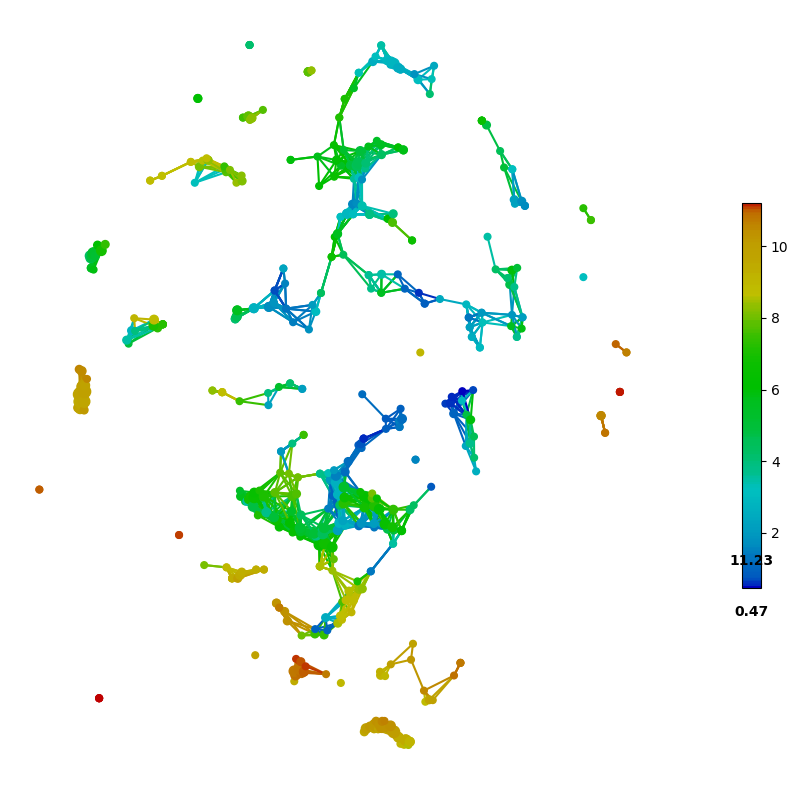

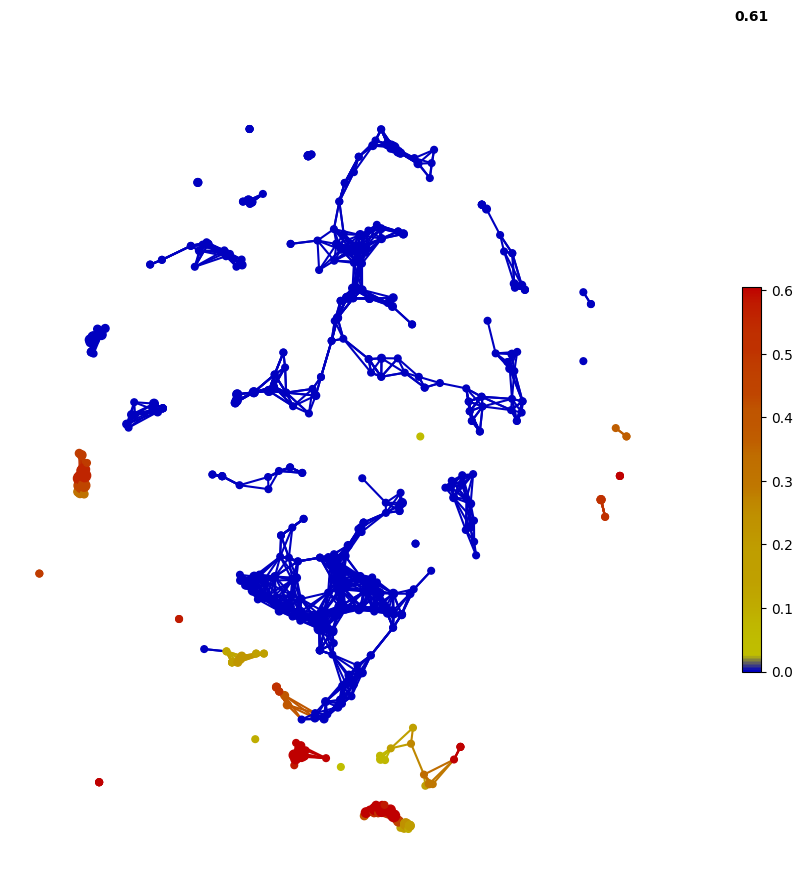

In [89]:
from tmap.tda.plot import Color
color = Color(metadata.loc[:,'hipca_Combined'],target_by='sample',dtype='numerical')
graph.show(color=color)

color = Color(enriched_scores.loc[:,'hipca_Combined'],target_by='node',dtype='numerical')
graph.show(color=color)

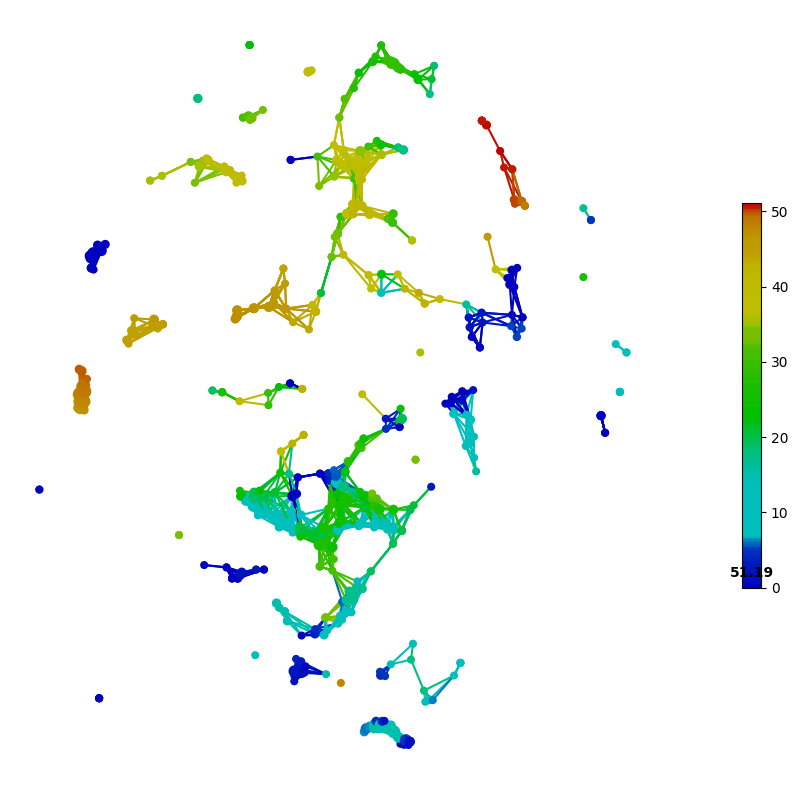

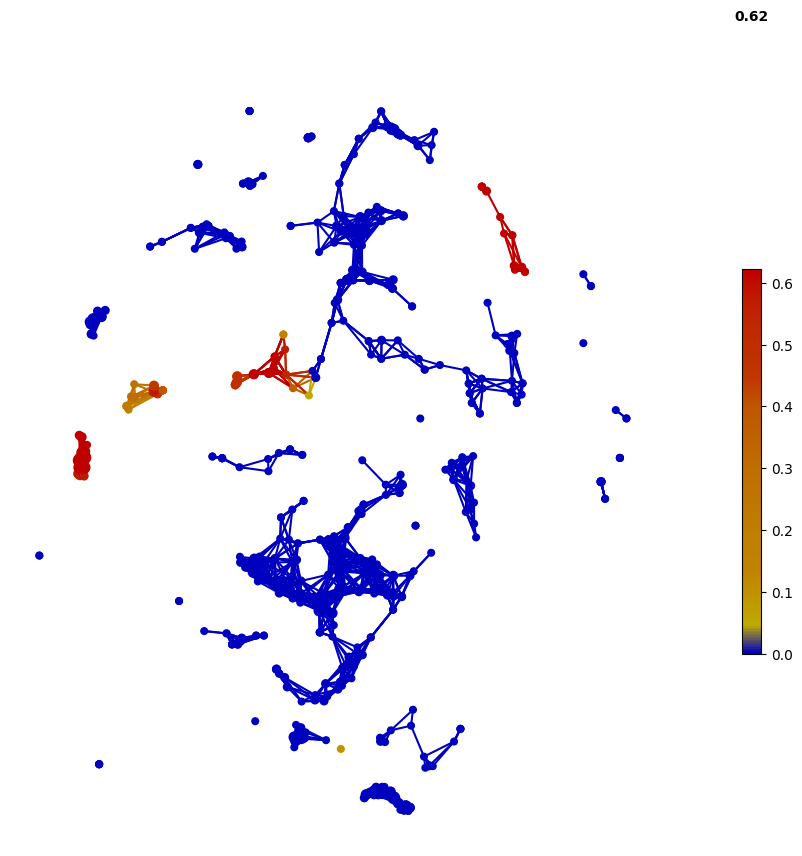

In [119]:
from tmap.tda.plot import Color
color = Color(X.loc[:,'Phocaeicola_dorei'],target_by='sample',dtype='numerical')
graph.show(color=color) 

color = Color(enriched_scores.loc[:,'Phocaeicola_dorei'],target_by='node',dtype='numerical')
graph.show(color=color)

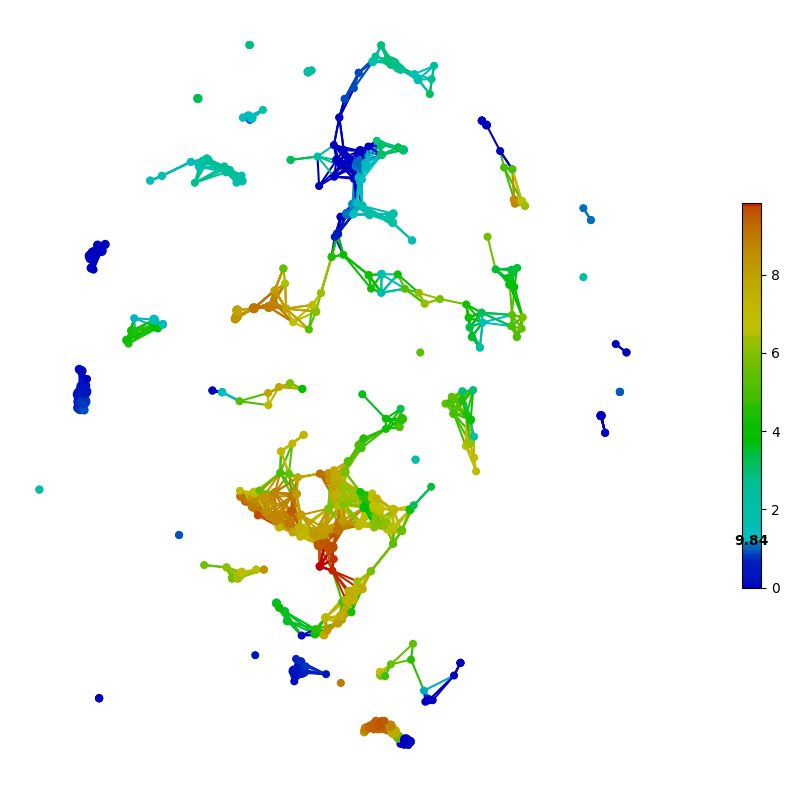

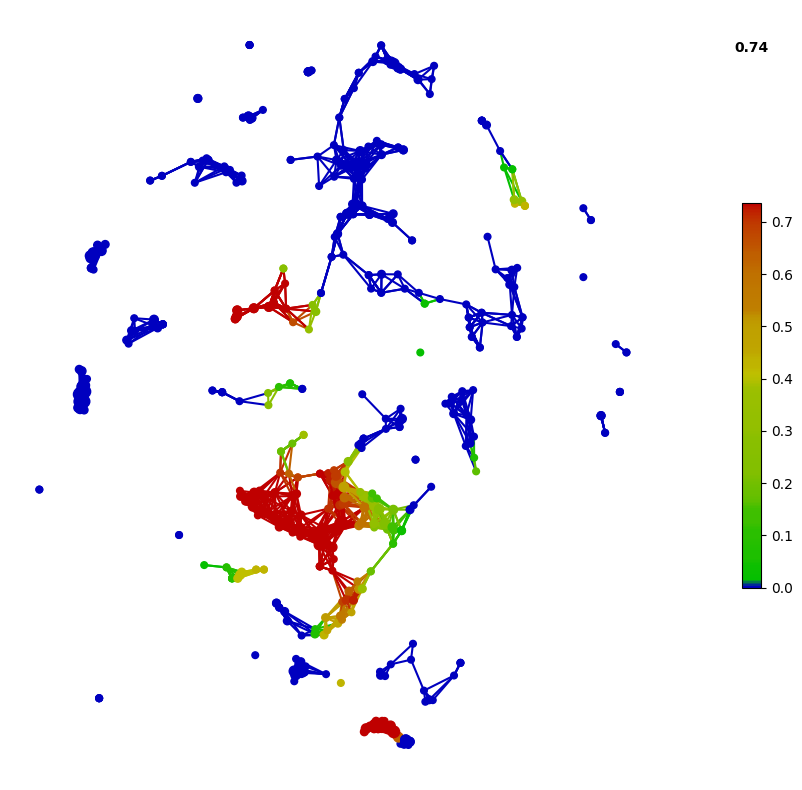

In [66]:
from tmap.tda.plot import Color
color = Color(X.loc[:,'Bacteroides_xylanisolvens'],target_by='sample',dtype='numerical')
graph.show(color=color) 

color = Color(enriched_scores.loc[:,'Bacteroides_xylanisolvens'],target_by='node',dtype='numerical')
graph.show(color=color)

# Co-enrichment relations

In [ ]:
import itertools
from tmap.netx.SAFE import get_significant_nodes
from tmap.netx.coenrichment_analysis import *
enriched_centroides, enriched_nodes = get_significant_nodes(graph=graph,
                                                            safe_scores=enriched_scores,
                                                            n_iter=n_iter,
                                                            pvalue=0.05,
                                                            r_neighbor=True
                                                            )
corrected_fe_dis = pairwise_coenrichment(graph,
                                         safe_scores=enriched_scores,
                                         _pre_cal_enriched=enriched_centroides)

cutoff_val = np.percentile(corrected_fe_dis.values.reshape(-1, 1), 0.5)
edges = []
for f1, f2 in itertools.combinations(corrected_fe_dis.index, 2):
    if corrected_fe_dis.loc[f1, f2] <= cutoff_val:
        edges.append((f1, f2, {'weight': 1 - corrected_fe_dis.loc[f1, f2]}))
        import networkx as nx
G = nx.from_edgelist(edges)
file_path = 'tmp_camda all genus and metadata.edges'
nx.write_edgelist(G, file_path)

edge_df = pd.read_csv(file_path, sep=' ', header=None)
edge_df.index = range(edge_df.shape[0])

all_nodes = list(set(list(edge_df.iloc[:, 0]) + list(edge_df.iloc[:, 1])))
node_df = pd.DataFrame(index=all_nodes, columns=['cat'])
for idx in range(edge_df.shape[0]):
    source_name = edge_df.iloc[idx, 0]
    end_name = edge_df.iloc[idx, 1]

    edge_df.loc[idx, 'weight'] = -np.log(corrected_fe_dis.loc[source_name, end_name])
node_df.index.name = 'feature'
edge_df = edge_df.drop([2, 3], axis=1)
edge_df.columns = ['Source', 'End', 'weight']
edge_df.to_csv(file_path, index=False, sep='\t')
node_df.to_csv(file_path.replace('edge', 'node'), sep='\t') 

building network...


  0%|          | 30/27634 [33:18<320:03:09, 41.74s/it] 

# Ranking of any features

In [64]:
from plotly import tools
import plotly.graph_objs as go
import plotly

fig = tools.make_subplots(1, 1)

safe_summary_metadata = safe_summary.reindex(metadata.columns)
sorted_df = safe_summary_metadata.sort_values('SAFE enriched score', ascending=False)

fig.append_trace(go.Bar(x=sorted_df.loc[:, 'SAFE enriched score'],
                        y=sorted_df.head(50).index,
                        marker=dict(line=dict(width=1)),
                        orientation='h',
                        showlegend=False), 1, 1)

fig.layout.yaxis.autorange = 'reversed'
fig.layout.margin.l = 200
fig.layout.height = 1500
plotly.offline.plot(fig)

/opt/tljh/user/lib/python3.9/site-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



>

'temp-plot.html'

In [155]:
sorted_df.head(200)

,SAFE total score,number of enriched nodes,number of enriched samples,SAFE enriched score,enriched abundance ratio,enriched SAFE score ratio
THRESYN-PWY_superpathway_of_L-threonine_biosynthesis_g_Bacteroides_Bacteroides_uniformis,102.412500,116,88,91.199584,0.456645,0.890512
PWY-724_superpathway_of_L-lysine_L-threonine_and_L-methionine_biosynthesis_II_g_Bacteroides_Bacteroides_uniformis,108.048117,113,88,88.393691,0.446917,0.818096
BRANCHED-CHAIN-AA-SYN-PWY_superpathway_of_branched_chain_amino_acid_biosynthesis_g_Bacteroides_Bacteroides_xylanisolvens,91.893251,101,82,77.048772,0.362519,0.838460
PWY-5103_L-isoleucine_biosynthesis_III_g_Bacteroides_Bacteroides_xylanisolvens,91.216361,98,81,75.272376,0.355606,0.825207
PWY-621_sucrose_degradation_III_(sucrose_invertase)_g_Bacteroides_Bacteroides_xylanisolvens,89.700702,98,86,74.785205,0.425560,0.833719
...,...,...,...,...,...,...
NONMEVIPP-PWY_methylerythritol_phosphate_pathway_I_g_Parabacteroides_Parabacteroides_merdae,71.330900,67,66,47.773881,0.422541,0.669750
PWY-7220_adenosine_deoxyribonucleotides_de_novo_biosynthesis_II_g_Bacteroides_Bacteroides_massiliensis,68.207151,67,62,47.773881,0.319437,0.700423
PWY-724_superpathway_of_L-lysine_L-threonine_and_L-methionine_biosynthesis_II_g_Faecalibacterium_Faecalibacterium_prausnitzii,75.425928,66,58,46.917180,0.320906,0.622030
PWY-5695_inosine_5-phosphate_degradation_g_Bacteroides_Bacteroides_massiliensis,71.540878,66,62,46.917180,0.332556,0.655809


# TDA category pathways

In [116]:
from __future__ import print_function
from matplotlib.pyplot import title
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from tmap.tda import mapper, Filter
from tmap.tda.cover import Cover
from tmap.tda.metric import Metric
from tmap.tda.plot import Color
from tmap.tda.utils import optimize_dbscan_eps
from tmap.test import load_data
import pandas as pd
# load taxa abundance data, sample metadata and precomputed distance matrix
#raw = pd.read_csv("Daniel/taxonomyorder.fil.txt",index_col=0)
raw = pd.read_csv("taxonomy.csv",index_col=0)
X = raw.T
metadata = pd.read_csv("metadata.csv",index_col=2) #sample metadata
dm = squareform(pdist(X, metric="braycurtis"))
#metadata = metadata.loc[X.index, :

# TDA Step1. initiate a Mapper
tm = mapper.Mapper(verbose=1)

# TDA Step2. Projection
metric = Metric(metric="precomputed")
lens = [Filter.MDS(components=[0, 1], metric=metric, random_state=100)]
projected_X = tm.filter(dm, lens=lens)

# Step4. Covering, clustering & mapping
eps = optimize_dbscan_eps(X, threshold=95)
clusterer = DBSCAN(eps=eps, min_samples=3)
cover = Cover(projected_data=MinMaxScaler().fit_transform(projected_X), resolution=61, overlap=0.91)
graph = tm.map(data=X, cover=cover, clusterer=clusterer)
print(graph.info())

Filtering by MDS.
...calculate Filter(which used to create cover) using the provided precomputed lens.


/opt/tljh/user/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



Filtering has been completed.


100%|██████████| 3721/3721 [00:01<00:00, 2275.39it/s]


Mapping on data (613, 2115) using lens (613, 2)
...minimal number of points in hypercube to do clustering: 3
...create 486 nodes.
...calculate projection coordinates of nodes.
...construct a TDA graph.
...create 2096 edges.
Finish TDA mapping

Graph
Contains 486 nodes and 391 samples
During constructing graph, 222 (63.78%) samples lost

Used params:

cluster params
algorithm: auto
eps: 28.320648883560203
leaf_size: 30
metric: euclidean
metric_params: None
min_samples: 3
n_jobs: None
p: None
cover params
r: 61
overlap: 0.91
lens params
lens_0:
components: [0, 1]
metric: precomputed




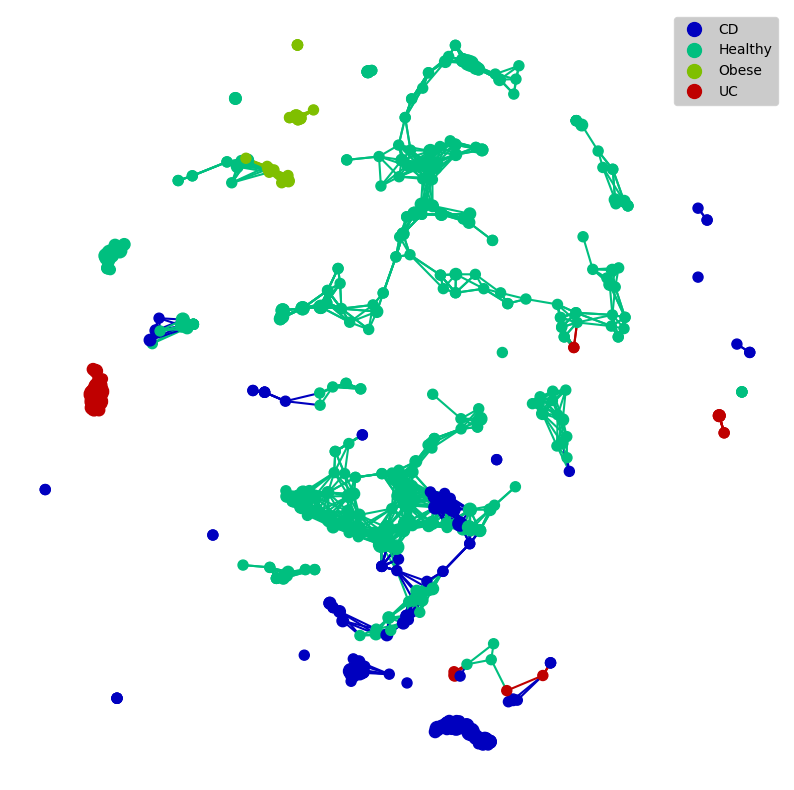

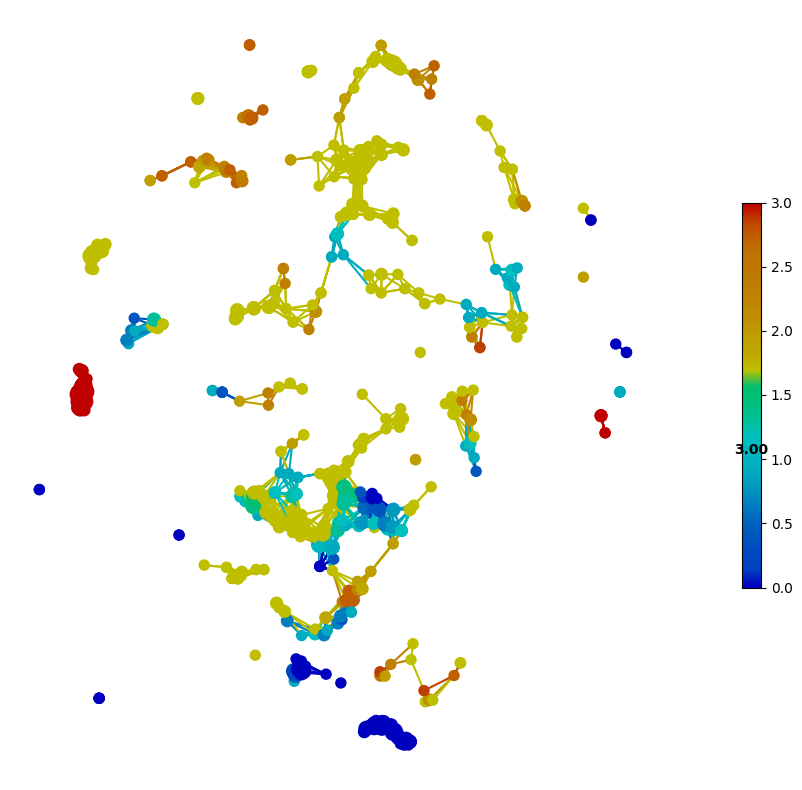

In [117]:
target_feature = 'Diagnosis'
color = Color(target=metadata.loc[:, target_feature],
              dtype="categorical",
              target_by="sample")
graph.show(color=color, fig_size=(10, 10), node_size=15, notshow=True)

color = Color(target=metadata.loc[:, target_feature],
              dtype="numerical",
              target_by="sample")
graph.show(color=color, fig_size=(10, 10), node_size=15, notshow=True)

# TDA category taxonomy

In [104]:
from __future__ import print_function
from matplotlib.pyplot import title
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from tmap.tda import mapper, Filter
from tmap.tda.cover import Cover
from tmap.tda.metric import Metric
from tmap.tda.plot import Color
from tmap.tda.utils import optimize_dbscan_eps
from tmap.test import load_data
import pandas as pd
# load taxa abundance data, sample metadata and precomputed distance matrix
#raw = pd.read_csv("Daniel/taxonomyorder.fil.txt",index_col=0)
raw = pd.read_csv("taxonomy.csv",index_col=0)
X = raw.T
#metadata = pd.read_csv("metadata.csv",index_col=2) #sample metadata
metadata = pd.read_csv("pred_camda_hipca_RFT_edi_metadata.csv",index_col=0) #sample metadata francisco
dm = squareform(pdist(X, metric="braycurtis"))
#metadata = metadata.loc[X.index, :

# TDA Step1. initiate a Mapper
tm = mapper.Mapper(verbose=1)

# TDA Step2. Projection
metric = Metric(metric="precomputed")
lens = [Filter.MDS(components=[0, 1], metric=metric, random_state=100)]
projected_X = tm.filter(dm, lens=lens)

# Step4. Covering, clustering & mapping
eps = optimize_dbscan_eps(X, threshold=95)
clusterer = DBSCAN(eps=eps, min_samples=3)
cover = Cover(projected_data=MinMaxScaler().fit_transform(projected_X), resolution=61, overlap=0.91)
graph = tm.map(data=X, cover=cover, clusterer=clusterer)
print(graph.info())

Filtering by MDS.
...calculate Filter(which used to create cover) using the provided precomputed lens.


/opt/tljh/user/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



Filtering has been completed.


100%|██████████| 3721/3721 [00:28<00:00, 131.53it/s]


Mapping on data (613, 2115) using lens (613, 2)
...minimal number of points in hypercube to do clustering: 3
...create 486 nodes.
...calculate projection coordinates of nodes.
...construct a TDA graph.
...create 2096 edges.
Finish TDA mapping

Graph
Contains 486 nodes and 391 samples
During constructing graph, 222 (63.78%) samples lost

Used params:

cluster params
algorithm: auto
eps: 28.320648883560203
leaf_size: 30
metric: euclidean
metric_params: None
min_samples: 3
n_jobs: None
p: None
cover params
r: 61
overlap: 0.91
lens params
lens_0:
components: [0, 1]
metric: precomputed




In [96]:
## Graficas METADATOS CAMDA
#target_feature = 'Diagnosis'
#color = Color(target=metadata.loc[:, target_feature],
#              dtype="categorical",
#              target_by="sample")
#graph.show(color=color, fig_size=(10, 10), node_size=15, notshow=True)

#color = Color(target=metadata.loc[:, target_feature],
#              dtype="numerical",
#              target_by="sample")
#graph.show(color=color, fig_size=(10, 10), node_size=15, notshow=True)

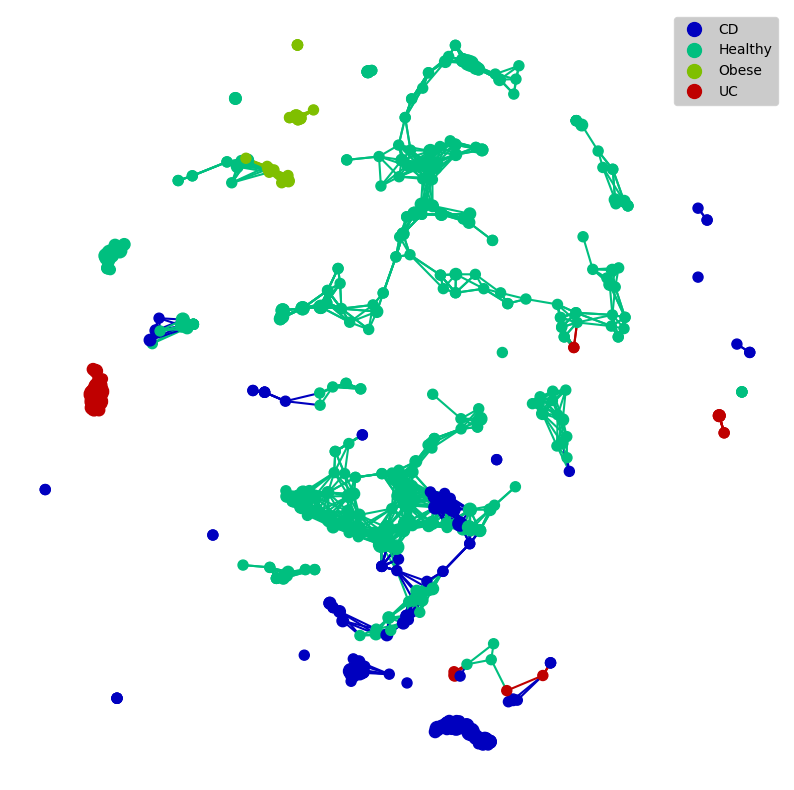

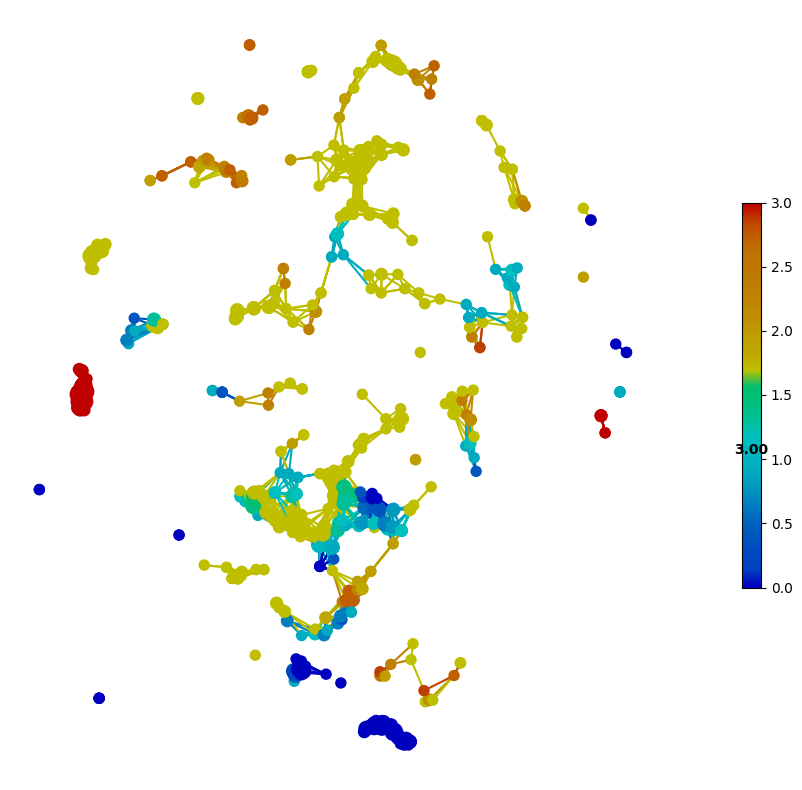

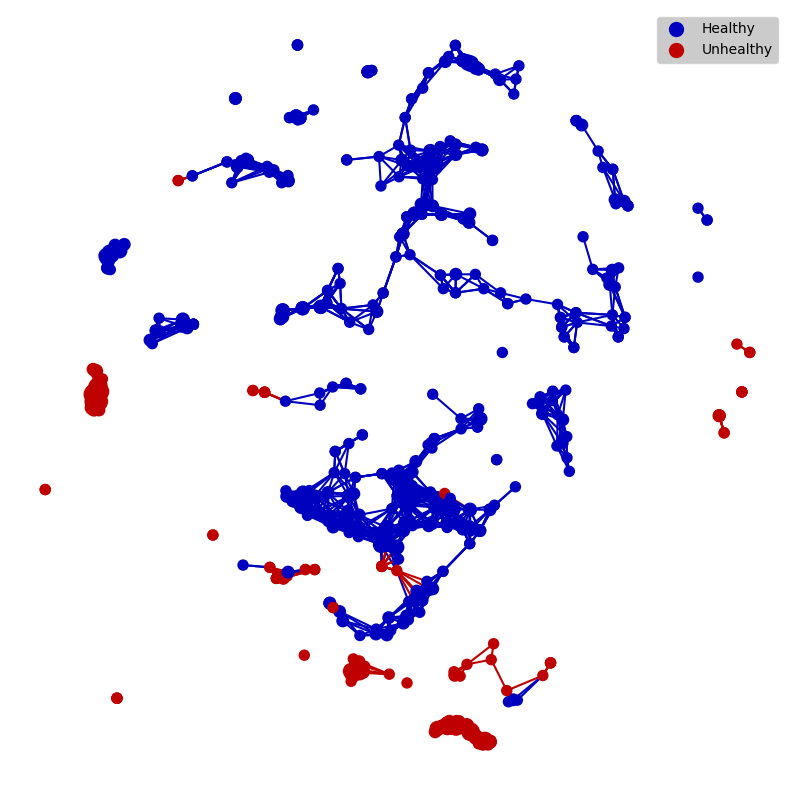

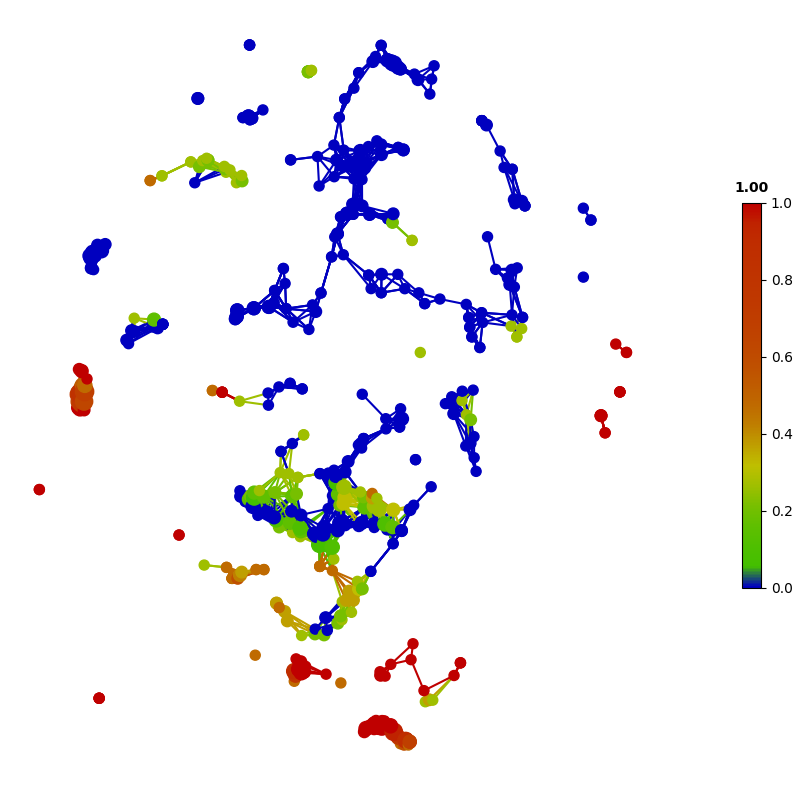

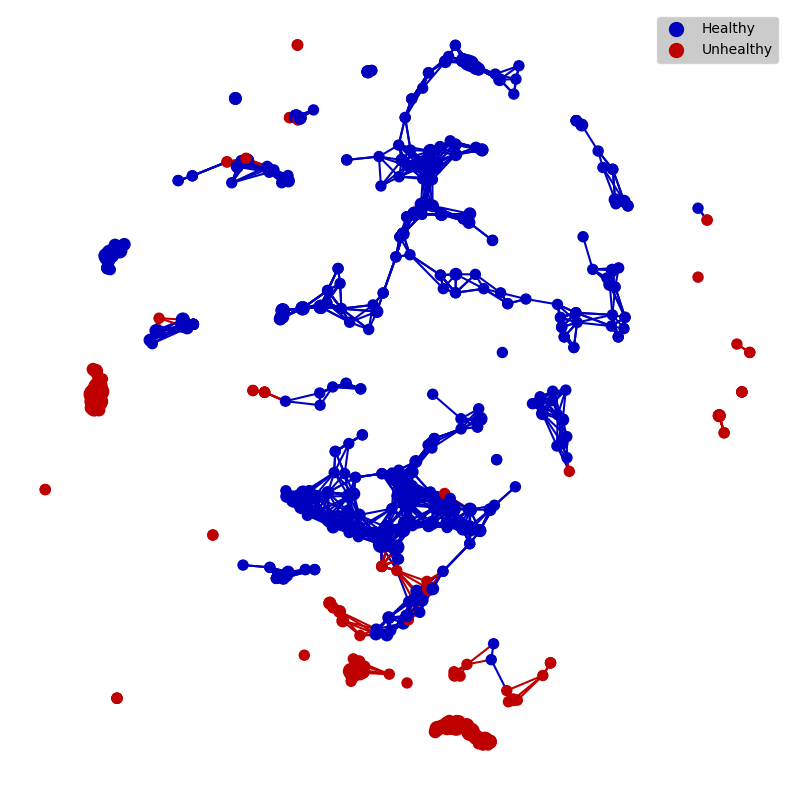

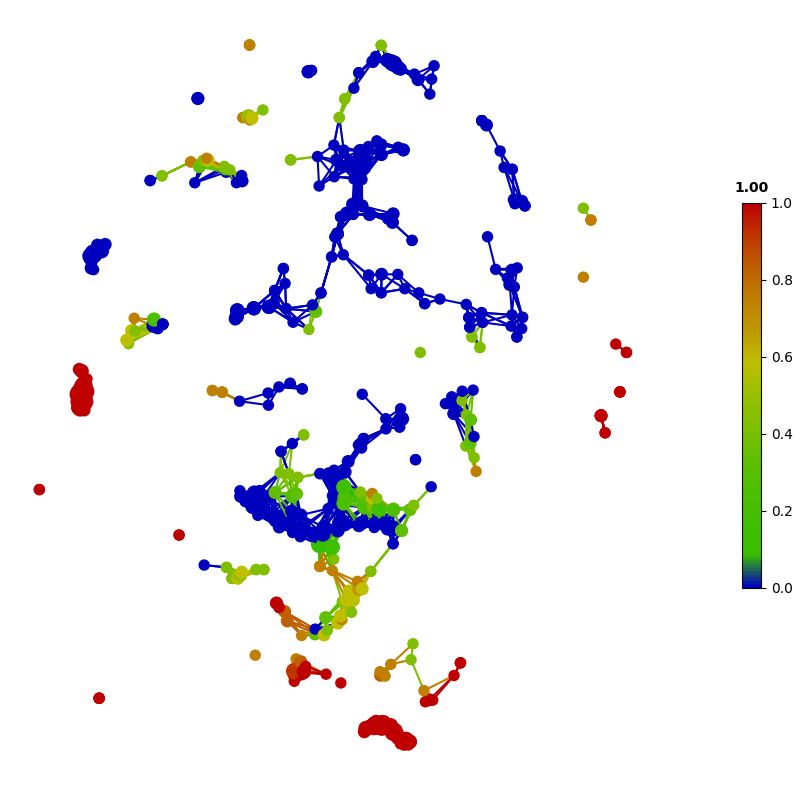

In [110]:
## Graficas METADATOS Fracisco
target_feature = 'metadata'
color = Color(target=metadata.loc[:, target_feature],
              dtype="categorical",
              target_by="sample")
graph.show(color=color, fig_size=(10, 10), node_size=15, notshow=True)

color = Color(target=metadata.loc[:, target_feature],
              dtype="numerical",
              target_by="sample")
graph.show(color=color, fig_size=(10, 10), node_size=15, notshow=True)

## Graficas METADATOS Fracisco
target_feature = 'hipca'
color = Color(target=metadata.loc[:, target_feature],
              dtype="categorical",
              target_by="sample")
graph.show(color=color, fig_size=(10, 10), node_size=15, notshow=True)

color = Color(target=metadata.loc[:, target_feature],
              dtype="numerical",
              target_by="sample")
graph.show(color=color, fig_size=(10, 10), node_size=15, notshow=True)

## Graficas METADATOS Fracisco
target_feature = 'RFT'
color = Color(target=metadata.loc[:, target_feature],
              dtype="categorical",
              target_by="sample")
graph.show(color=color, fig_size=(10, 10), node_size=15, notshow=True)

color = Color(target=metadata.loc[:, target_feature],
              dtype="numerical",
              target_by="sample")
graph.show(color=color, fig_size=(10, 10), node_size=15, notshow=True)